In [1]:
!pip install dask_ml imblearn catboost seaborn autokeras

In [2]:
import tensorflow as tf

# Проверка доступных устройств GPU
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Если GPU присутствуют, попробуйте их использовать
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU devices: {gpus}")
    except RuntimeError as e:
        # Инициализация GPU происходит после загрузки TensorFlow
        print(e)
else:
    print("No GPU devices found.")

2024-02-05 00:30:13.954854: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 00:30:14.000696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 00:30:14.000733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 00:30:14.001869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 00:30:14.009227: I tensorflow/core/platform/cpu_feature_guar

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-05 00:30:16.054051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 00:30:16.101835: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 00:30:16.103067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Reseach

## DS Libraries

In [3]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dask_ml.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Data preparation

Определить, какие признаки показа являются хорошими предикторами события (например, события fclick), упорядочить их в порядке убывания вместе с численной оценкой их качества

In [4]:
def read_csv_to_dataframe(csv_file_path, delimiter=","):
    """ """
    try:
        # Use pandas to read the CSV file
        dataframe = pd.read_csv(csv_file_path, delimiter=delimiter)
        return dataframe
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

In [5]:
features_file_path = "interview.X.csv"
target_file_path = "interview.y.csv"

features_df = read_csv_to_dataframe(features_file_path)
target_df = read_csv_to_dataframe(target_file_path)

merged_df = features_df.merge(target_df, on="uid", how="left")

del features_df
del target_df

In [6]:
merged_df.dropna(inplace=True)
merged_df.drop_duplicates(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

In [7]:
merged_df["is_fclick"] = (merged_df["tag"] == "fclick").astype(int)
merged_df.drop("tag", axis=1, inplace=True)

In [8]:
merged_df.shape

(12363, 11)

# Корреляционная матрица

Корреляционной матрицей предоставляет информацию о степени линейной взаимосвязи между парами переменных. Каждый элемент матрицы представляет собой коэффициент корреляции между двумя соответствующими признаками. Этот коэффициент корреляции может принимать значения от -1 до 1, где:

1 указывает на положительную линейную корреляцию (высокие значения одной переменной сопутствуют высоким значениям другой и наоборот).
-1 указывает на отрицательную линейную корреляцию (высокие значения одной переменной сопутствуют низким значениям другой и наоборот).
0 указывает на отсутствие линейной корреляции между переменными.

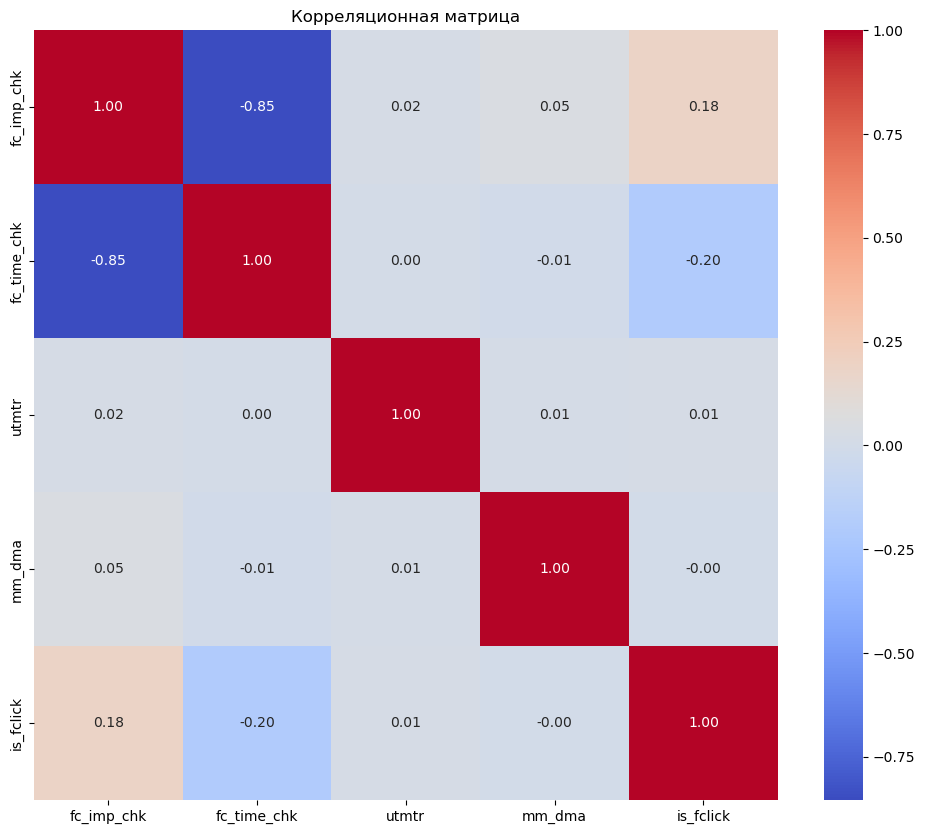

In [9]:
# Вычисление корреляционной матрицы
correlation_matrix = merged_df[
    ["fc_imp_chk", "fc_time_chk", "utmtr", "mm_dma", "is_fclick"]
].corr()

# Использование seaborn для визуализации
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

In [10]:
# Сортировка признаков по убыванию корреляции
sorted_correlations = correlation_matrix.abs().sort_values(
    by="is_fclick", ascending=True
)

# Выведите результаты
print("Топ признаков по убыванию корреляции с", "is_fclick")
print(sorted_correlations.iloc[::-1])

Топ признаков по убыванию корреляции с is_fclick
             fc_imp_chk  fc_time_chk     utmtr    mm_dma  is_fclick
is_fclick      0.182984     0.200295  0.014849  0.000213   1.000000
fc_time_chk    0.854737     1.000000  0.003409  0.012002   0.200295
fc_imp_chk     1.000000     0.854737  0.018547  0.048873   0.182984
utmtr          0.018547     0.003409  1.000000  0.010896   0.014849
mm_dma         0.048873     0.012002  0.010896  1.000000   0.000213


In [11]:
X = merged_df.drop(columns=["uid", "is_fclick", "site_id", "model", "hardware"])
y = merged_df["is_fclick"]

del merged_df

### Add features

In [12]:
# Assuming 'df' in DataFrame and it has a 'reg_time' with the datetime strings
X["reg_time"] = pd.to_datetime(X["reg_time"])

# Now extract date features from the 'reg_time' column
X["year"] = X["reg_time"].dt.year
X["month"] = X["reg_time"].dt.month
X["day"] = X["reg_time"].dt.day
X["weekday"] = X["reg_time"].dt.weekday  # Monday=0, Sunday=6

# X['hour'] = X['reg_time'].dt.hour
# X['minute'] = X['reg_time'].dt.minute
# X['second'] = X['reg_time'].dt.second

# Now drop the original 'reg_time' column
X = X.drop("reg_time", axis=1)

In [13]:
df_X_dask = dd.from_pandas(X, npartitions=8)  # 8 - количество частей

## Train model

In [14]:
import dask
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Extract categorical columns
categorical_columns = ["osName"]

# Categorize the columns to ensure known categories
df_X_dask = df_X_dask.categorize(columns=categorical_columns)

In [15]:
# Concatenate encoded features with original numeric features
X_dask_encoded = dd.get_dummies(df_X_dask)

In [16]:
X_dask_encoded.compute().shape

(12363, 14)

In [17]:
import dask_ml.model_selection as dcv

# Convert the Dask DataFrame to a Pandas DataFrame
X_dask_encoded_pd = X_dask_encoded.compute()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = dcv.train_test_split(
    X_dask_encoded_pd, y, test_size=0.3, random_state=42, shuffle=True
)

In [18]:
del X_dask_encoded

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [20]:
# Сортировка признаков по убыванию корреляции
sorted_correlations = correlation_matrix.abs().sort_values(
    by="is_fclick", ascending=True
)

# Выведите результаты
print("Топ признаков по убыванию корреляции с", "is_fclick")
print(sorted_correlations.iloc[::-1])

Топ признаков по убыванию корреляции с is_fclick
             fc_imp_chk  fc_time_chk     utmtr    mm_dma  is_fclick
is_fclick      0.182984     0.200295  0.014849  0.000213   1.000000
fc_time_chk    0.854737     1.000000  0.003409  0.012002   0.200295
fc_imp_chk     1.000000     0.854737  0.018547  0.048873   0.182984
utmtr          0.018547     0.003409  1.000000  0.010896   0.014849
mm_dma         0.048873     0.012002  0.010896  1.000000   0.000213


## Catboost

In [21]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=15000, learning_rate=0.1, depth=6, loss_function="Logloss", verbose=1000
)

# Fit model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Save model
model.save_model("catboost_classifier.model")

0:	learn: 0.6736777	total: 49.8ms	remaining: 12m 26s
1000:	learn: 0.4540533	total: 3.49s	remaining: 48.8s
2000:	learn: 0.4211726	total: 6.93s	remaining: 45s
3000:	learn: 0.4026531	total: 10.4s	remaining: 41.4s
4000:	learn: 0.3907851	total: 13.8s	remaining: 38s
5000:	learn: 0.3826584	total: 17.2s	remaining: 34.5s
6000:	learn: 0.3766741	total: 20.7s	remaining: 31s
7000:	learn: 0.3721743	total: 24.2s	remaining: 27.6s
8000:	learn: 0.3686076	total: 27.6s	remaining: 24.1s
9000:	learn: 0.3658672	total: 30.9s	remaining: 20.6s
10000:	learn: 0.3636362	total: 34.3s	remaining: 17.1s
11000:	learn: 0.3618490	total: 37.6s	remaining: 13.7s
12000:	learn: 0.3604089	total: 40.8s	remaining: 10.2s
13000:	learn: 0.3591823	total: 44.1s	remaining: 6.79s
14000:	learn: 0.3581797	total: 47.3s	remaining: 3.38s
14999:	learn: 0.3572686	total: 50.4s	remaining: 0us
Accuracy: 0.6012402264761392


In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.65      0.69      2596
           1       0.38      0.50      0.43      1113

    accuracy                           0.60      3709
   macro avg       0.56      0.57      0.56      3709
weighted avg       0.64      0.60      0.61      3709



# Let's try AutoKeras

In [23]:
from tensorflow.keras.metrics import AUC, Precision, Recall

import autokeras as ak

clf = ak.StructuredDataClassifier(max_trials=30)


clf.fit(X_train, y_train, epochs=50)

Using TensorFlow backend
Reloading Tuner from ./structured_data_classifier/tuner0.json


2024-02-05 00:31:13.802752: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 00:31:13.804328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 00:31:13.805510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/50


2024-02-05 00:31:26.544914: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f51e842ad50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-05 00:31:26.544953: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-02-05 00:31:26.551281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-05 00:31:26.571673: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707093086.658575   39612 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 [==============================] - 4s 4ms/step - loss: 0.4368 - accuracy: 0.7796
Epoch 2/50
375/375 [==============================] - 1s 4ms/step - loss: 0.5744 - accuracy: 0.7430
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 0.5524 - accuracy: 0.7330
Epoch 4/50
375/375 [==============================] - 1s 4ms/step - loss: 0.5824 - accuracy: 0.7210
Epoch 5/50
375/375 [==============================] - 1s 4ms/step - loss: 0.5540 - accuracy: 0.7194
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.5550 - accuracy: 0.7171
Epoch 7/50
375/375 [==============================] - 1s 4ms/step - loss: 0.5519 - accuracy: 0.7154
Epoch 8/50
375/375 [==============================] - 1s 4ms/step - loss: 0.5516 - accuracy: 0.7162
Epoch 9/50
375/375 [==============================] - 1s 4ms/step - loss: 0.5499 - accuracy: 0.7165
Epoch 10/50
375/375 [==============================] - 1s 4ms/step - loss: 0.5293 - accuracy: 0.7292
Epoch 11/5

INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets


In [24]:
predictions = clf.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

116/116 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.16      0.27      2596
           1       0.33      0.97      0.49      1113

    accuracy                           0.40      3709
   macro avg       0.63      0.56      0.38      3709
weighted avg       0.74      0.40      0.34      3709



In [25]:
model = clf.export_model()
model.save("model_autokeras", save_format="tf")

INFO:tensorflow:Assets written to: model_autokeras/assets


INFO:tensorflow:Assets written to: model_autokeras/assets
